# setup

In [ ]:
import socket
import os
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tuning_fun as tu
import emulator_fun as ef
import numpy as np
from tqdm.keras import TqdmCallback
import pandas as pd
import time
import netCDF4 as nc
import load_ppe_fun as lp
from tensorflow.keras import layers
import keras
from tensorflow.keras.losses import Loss
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import TerminateOnNaN
from scipy.stats import boxcox
from tqdm.auto import tqdm
import MCMC_fun as mf
import util_fun as uf
import importlib

2025-09-18 14:25:47.634782: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-18 14:25:47.648162: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758219947.660978 1511846 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758219947.665044 1511846 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758219947.677106 1511846 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Physical devices cannot be modified after being initialized
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1758219949.911869 1511846 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38366 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 3g.40gb, pci bus id: 0000:e1:00.0, compute capability: 8.0


In [ ]:
# set up and check if GPU is used

hostname = socket.gethostname()
if hostname == 'simurgh':
    os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-b5356651-0d8e-5cd1-bdf3-ccbb8b221031"

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
        #     tf.config.experimental.set_virtual_device_configuration(
        #     gpu,
        #     [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=20480)]
        # )
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

print(gpus)

<module 'load_ppe_fun' from '/home/arthurhu/BOSS_PPE/load_ppe_fun.py'>

# HP tuning

## pre-processing

In [57]:
run_name = 'condevap_ppe_46_ssmomvals'
filename = run_name + '_N5000.nc'

params_train = ef.get_params(lp.nc_dir, filename)
transform_method = 'standard_scaler'
x_train, x_val, y_train, y_val, tgt_data, tgt_initvar_matrix, ppe_info, scalers = \
    ef.get_train_val_tgt_data(lp.nc_dir, filename, params_train, transform_method, 
                              l_multi_output=True, set_nan_to_neg1001=True)

nobs = ppe_info['nobs']
nvar = ppe_info['nvar']
npar = ppe_info['npar']
n_init = ppe_info['n_init']
nparam_init = ppe_info['nparam_init']

Transforming data...: 100%|██████████| 4/4 [00:00<00:00, 1707.78it/s]

In [58]:
# fig = plt.figure(figsize=(15, 5))
# gs = gridspec.GridSpec(1,nvar)
# for i, eff0 in enumerate(eff0s):
#     ax = fig.add_subplot(gs[i])
#     _ = plt.hist([ppe_data[i].flatten(), tgt_data[i].flatten()],
#                  bins=100,
#                  density=True,
#                  label=['BOSS PPE', 'target'])
#     plt.legend()
#     # plt.yscale('log')
#     plt.title(var_constraints[i])

Next, try out different ML architectures...

## CRPS

In [59]:
importlib.reload(tu)

<module 'tuning_fun' from '/home/arthurhu/BOSS_PPE/tuning_fun.py'>

In [60]:
proj_name = 'crps2_' + run_name + '_' + transform_method
varcons = ppe_info['var_constraints']
y_train_nopres = {k: v for k, v in y_train.items() if 'presence_' not in k}
y_val_nopres = {k: v for k, v in y_val.items() if 'presence_' not in k}

nparam_init = ppe_info['nparam_init']
tuner = kt.RandomSearch(
    lambda hp: tu.build_reg_crps_model(hp, nparam_init, varcons, nobs),
    objective="val_loss",
    max_trials=25,
    directory='hp_tuning/crps',
    project_name=proj_name,
)

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(
    x_train,
    y_train_nopres,
    epochs=25,
    validation_data=(x_val, y_val_nopres),
    callbacks=([stop_early, TerminateOnNaN()])
)

# Retrieve the best hyperparameters and build the best model:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)

Trial 25 Complete [00h 00m 25s]
val_loss: 0.8518325090408325

Best val_loss So Far: 0.7503511905670166
Total elapsed time: 00h 10m 37s


In [61]:
best_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 192)       │      3,648 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 96)        │     18,528 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      3,104 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean_M0_ss (Dense)  │ (None, 2)         │         66 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean_M3_ss (Dense)  │ (None, 2)         │         66 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean_Mx_ss (Dense)  │ (None, 2)         │         66 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean_My_ss (Dense)  │ (None, 2)         │         66 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,544 (99.78 KB)

 Trainable params: 25,544 (99.78 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50)

history = best_model.fit(
    x=x_train,
    y=y_train_nopres,
    epochs=1000,
    verbose=0,
    validation_data=(x_val, y_val_nopres),
    callbacks=[TqdmCallback(verbose=1), stop_early]
)

# save model:
best_model.save(f'models/{proj_name}.keras')

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

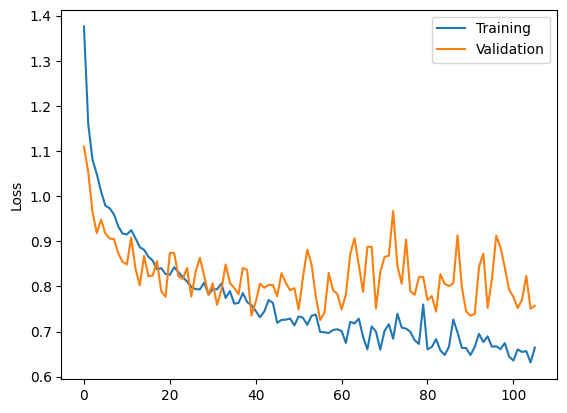

In [63]:
plt.figure()
plt.plot(history.epoch, history.history['loss'], label='Training')
plt.plot(history.epoch, history.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.legend()

## multi-output (explicit) model

In [5]:
importlib.reload(tu)

<module 'tuning_fun' from '/home/arthurhu/BOSS_PPE/tuning_fun.py'>

In [ ]:
proj_name = 'multioutput_unc_' + run_name + '_' + transform_method
varcons = ppe_info['var_constraints']
nparam_init = ppe_info['nparam_init']
tuner = kt.RandomSearch(
    lambda hp: tu.build_classreg_unc_model_simple(hp, nparam_init, varcons, nobs),
    objective="val_loss",
    max_trials=25,
    directory='hp_tuning/multi-output',
    project_name=proj_name,
)

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(
    x_train,
    y_train,
    epochs=25,
    validation_data=(x_val, y_val),
    callbacks=([stop_early, TerminateOnNaN()])
)

# Retrieve the best hyperparameters and build the best model:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)

Trial 25 Complete [00h 01m 47s]
val_loss: 1.1667722463607788

Best val_loss So Far: 1.065772294998169
Total elapsed time: 01h 13m 25s


In [7]:
best_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 96)        │      1,824 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 192)       │     18,624 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 192)       │     37,056 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 96)        │     18,528 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 160)       │     15,520 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ M0 (Dense)          │ (None, 85680)     │ 13,794,480 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ M3 (Dense)          │ (None, 85680)     │ 13,794,480 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Mx (Dense)          │ (None, 85680)     │ 13,794,480 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ My (Dense)          │ (None, 85680)     │ 13,794,480 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ presence_M0 (Dense) │ (None, 42840)     │  6,897,240 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ presence_M3 (Dense) │ (None, 42840)     │  6,897,240 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ presence_Mx (Dense) │ (None, 42840)     │  6,897,240 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ presence_My (Dense) │ (None, 42840)     │  6,897,240 │ dense_9[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 82,858,432 (316.08 MB)

 Trainable params: 82,858,432 (316.08 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50)

history = best_model.fit(
    x=x_train,
    y=y_train,
    epochs=10000,
    verbose=0,
    validation_data=(x_val, y_val),
    callbacks=[TqdmCallback(verbose=1), stop_early]
)

# save model:
best_model.save(f'models/{proj_name}.keras')

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

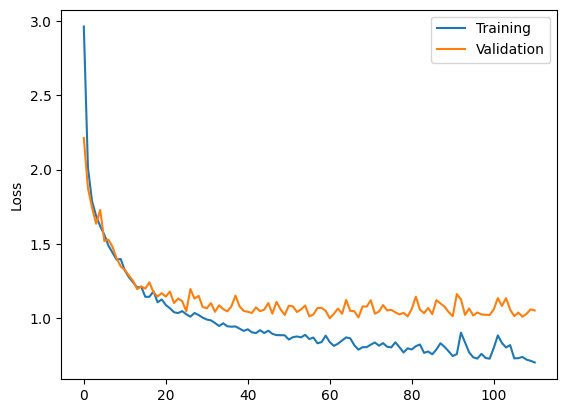

In [9]:
plt.figure()
plt.plot(history.epoch, history.history['loss'], label='Training')
plt.plot(history.epoch, history.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.legend()

## validation

In [64]:
# proj_name = 'multioutput_condcoal_46_momvals_standard_scaler_asinh'
# best_model = tf.keras.models.load_model('models/' + proj_name + '.keras', compile=False)
# proj_name


In [76]:
importlib.reload(ef)

<module 'emulator_fun' from '/home/arthurhu/BOSS_PPE/emulator_fun.py'>

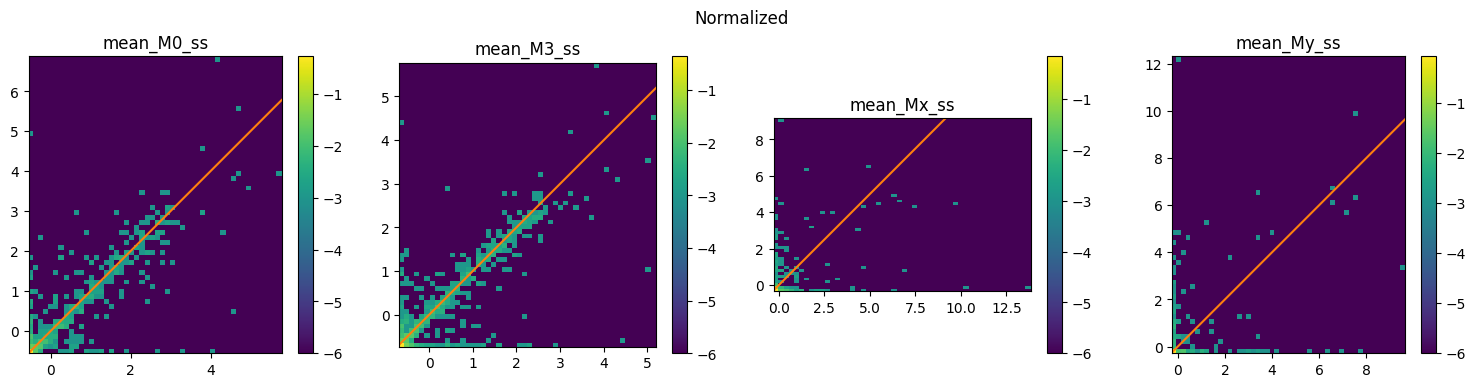

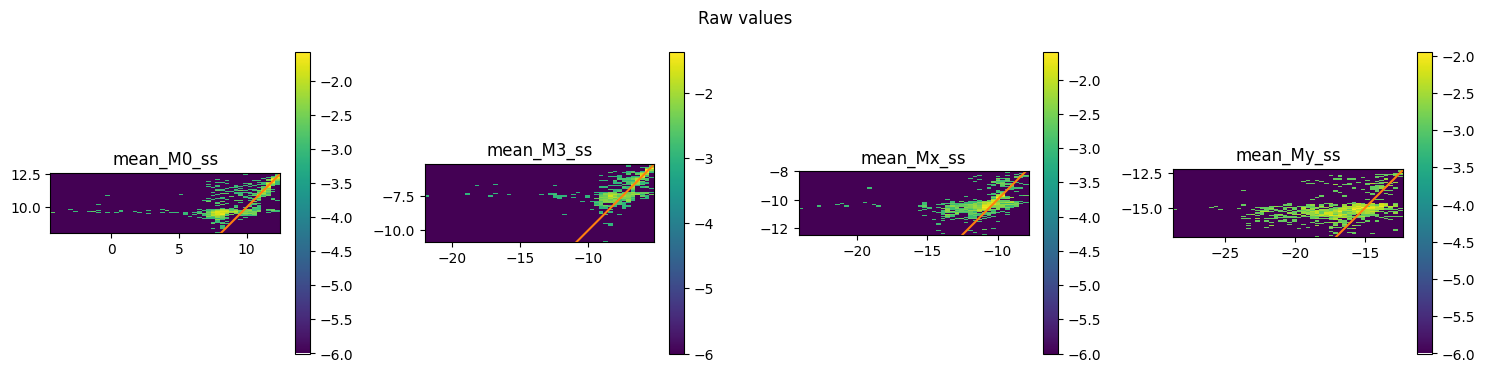

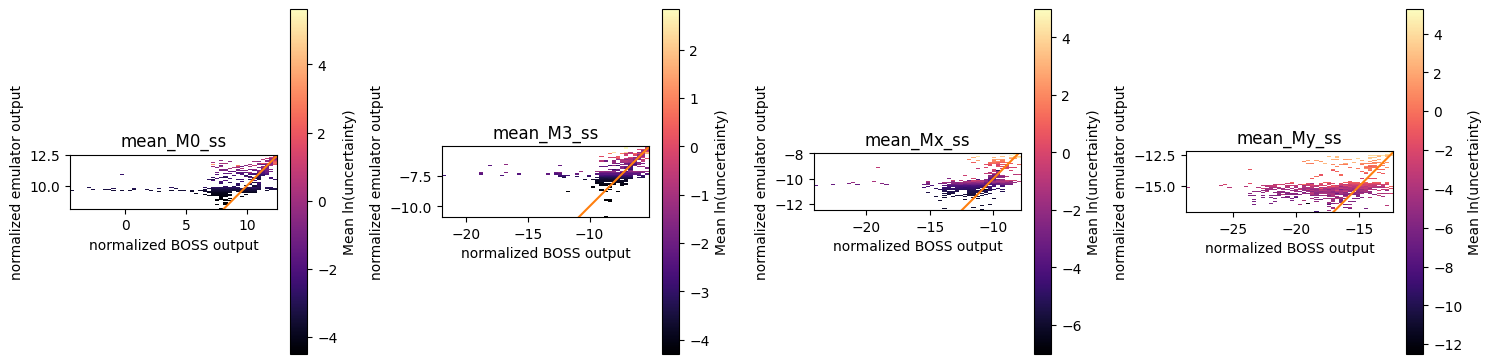

In [77]:
ef.plot_emulator_results(x_val, y_val, best_model, ppe_info, transform_method, scalers, plot_uncertainty=True)

In [78]:
# List top memory variables
# top_vars = uf.get_top_memory_vars(globals())
uf.detailed_memory_analysis()
# # Free likely iterated/temporary variables
# free_iterated_vars(locals())

# # Optionally, show top memory variables again after cleanup
# print("\nAfter cleanup:")
# get_top_memory_vars(locals())

=== Memory Analysis ===
RSS (Resident Set Size): 10.52 GB
VMS (Virtual Memory Size): 188.24 GB
Shared Memory: 0.61 GB
Text Segment: 0.00 GB
Data Segment: 22.14 GB

⚠️  Large VMS-RSS gap: 177.73 GB
This might indicate memory fragmentation or external libraries


# MCMC

## setup

In [121]:
# proj_name = 'crps_condcoal_46_momvals_standard_scaler_asinh'
# best_model = tf.keras.models.load_model('models/' + proj_name + '.keras', compile=False)

In [122]:
# MCMC
nchains = 6
num_burnin_steps = 1000
num_samples = 2000

# log prob function related
tau = 0.05
inflate_factor = 10.

In [123]:
params_train

{'pnames': array(['a0evap1_db', 'a0evap2_db', 'bm0evap1', 'bm0evap2', 'bx0evap1',
        'bx0evap2', 'by0evap1', 'by0evap2', 'aevap_db', 'bmevap',
        'bx3evap', 'bxxevap', 'bxyevap', 'by3evap', 'byxevap', 'byyevap',
        'a0coal_db', 'bmcoal', 'bncoal', 'bx0coal', 'bxscoal', 'bxxcoal',
        'bxycoal', 'by0coal', 'byscoal', 'byxcoal', 'byycoal',
        'mtrans0_db', 'afall_db', 'bnfall', 'bx0fall', 'bx3fall',
        'bxxfall', 'bxyfall', 'by0fall', 'by3fall', 'byxfall', 'byyfall',
        'mlim_db'], dtype=object),
 'vals': masked_array(
   data=[[ 2.48492090e+02,  1.95475980e+00, -5.78694496e+01, ...,
          -3.32733917e+00,  2.15747643e+00,  4.80745506e+00],
         [ 1.26856695e+02,  3.05605242e+00,  1.56763287e+01, ...,
           4.27430391e+00, -4.38474178e-01,  3.86191678e+00],
         [ 3.82993376e+02,  6.93260585e-01,  1.00569984e+02, ...,
           3.74231577e+00, -1.89582825e+00, -1.62271535e+00],
         ...,
         [ 3.36874288e+02,  2.20347040e+00,  

In [124]:
tgt_data_tf32 = tf.cast(tgt_data, tf.float32)
param_interest_idx = params_train['param_interest_idx']

orig_param_csv = '/home/arthurhu/CloudBOSS/param_csv/param_consolid_offline.csv'
# target_param_csv = '/home/arthurhu/CloudBOSS/param_csv/param_test.csv'

param_table = pd.read_csv(orig_param_csv)
param_names = param_table.columns[1+param_interest_idx].to_list()

# target_param_table = pd.read_csv(target_param_csv)

param_mean = param_table.values[0, 1+param_interest_idx].astype(np.float32)
param_std = param_table.values[1, 1+param_interest_idx].astype(np.float32)
# target_param_mean = target_param_table.values[0, 1+param_interest_idx].astype(np.float32)
nparam = len(param_names)

print_table = pd.DataFrame({'param names': param_names, 'prior mean': param_mean})
print(print_table)

   param names  prior mean
0   a0evap1_db   21.864029
1   a0evap2_db  -29.553640
2     bm0evap1   -0.003249
3     bm0evap2   -3.397290
4     bx0evap1    5.420265
5     bx0evap2    5.522030
6     by0evap1   -2.747893
7     by0evap2   -2.024920
8     aevap_db  -66.979874
9       bmevap    0.363778
10     bx3evap   -0.763994
11     bxxevap   -0.708984
12     bxyevap    0.289477
13     by3evap    0.281403
14     byxevap    0.240856
15     byyevap    0.217469


In [125]:
tgt_sim_ics = np.concatenate(tgt_initvar_matrix, axis=1)
nvar = len(ppe_info['var_constraints'])
n_tgt_ics = tgt_data[0].shape[0]

IC_with_dummy = np.concatenate((tgt_sim_ics, np.zeros([n_tgt_ics, npar])), axis=1)
IC_norm = scalers['x'].transform(IC_with_dummy)[:,:n_init].astype('float32')
IC_norm_3d = tf.tile(IC_norm[None, :, :], [nchains, 1, 1])
batch_size = nchains * n_tgt_ics
tgt_data_tf32_chain = tf.tile(tgt_data_tf32[None, :, :, :], [nchains, 1, 1, 1])
varcons = ppe_info['var_constraints']

## set up log prob function

In [126]:
tfd = tfp.distributions
tfb = tfp.bijectors
tfs = tfp.experimental.stats

def get_BOSSemu_lp(params_sigma, l_diag=False):
    emu_mu_list, emu_sigma_list, emu_pres_list, obs_score_list = [], [], [], []
    
    # priors on parameters

    params = params_sigma
    params_3d = tf.tile(params[:, None, :], [1, n_tgt_ics, 1])
    theta=tfb.Sigmoid().forward(params_3d)
    param_lp = tf.reduce_sum(tf.math.log(theta) + tf.math.log1p(-theta), axis=[1,2])

    if l_diag:
        # print('input:', params_3d[0,0,:].numpy())
        print('scaled parameters:', theta[0,0,:].numpy())

    # likelihood
    input_norm3d = tf.concat([IC_norm_3d, theta], axis=-1) # nchains x n_tgt_ics x n_input
    input_norm2d  = tf.reshape(input_norm3d, [batch_size, nparam_init])
    y_emu = best_model(input_norm2d) # nvar * n_tgt_ics x nobs
    if type(y_emu) is dict:
        for i, varcon in enumerate(varcons):
            pres = tf.ones([nchains, n_tgt_ics, nobs[i]], tf.float32)
            if f'presence_{varcon}' in y_emu.keys():
                pres   = tf.reshape(tf.cast(y_emu[f'presence_{varcon}'], tf.float32),
                                    [nchains, n_tgt_ics, nobs[i]])
            full   = tf.reshape(tf.cast(y_emu[varcon], tf.float32),
                                [nchains, n_tgt_ics, 2*nobs[i]])
            mu     = full[..., :nobs[i]]
            rawsig = full[..., nobs[i]:]  # raw scale; softplus later
            emu_pres_list.append(pres)
            emu_mu_list.append(mu)
            emu_sigma_list.append(rawsig)
        emu_tf32_presence_chain = tf.transpose(tf.stack(emu_pres_list),  [1,0,2,3])  # [chain, var, ic, obs]
        emu_mu_chain            = tf.transpose(tf.stack(emu_mu_list),    [1,0,2,3])
        emu_sigma_chain         = tf.transpose(tf.stack(emu_sigma_list), [1,0,2,3])
    else:
        raise ValueError('`y_emu` is not a dictionary. Not yet implemented.')

    for ichain in range(nchains):
        presence_pred = emu_tf32_presence_chain[ichain, ...]   # [nvar, n_ic, nobs]
        mu_pred       = emu_mu_chain[ichain, ...]
        sig_pred      = emu_sigma_chain[ichain, ...]
        y_true        = tgt_data_tf32                          # [nvar, n_ic, nobs]

        finite_mask = tf.math.is_finite(y_true)
        finite_w    = tf.stop_gradient(tf.cast(finite_mask, tf.float32))

        # soft presence gate (same as you had)
        thresh = tf.constant(0.1, tf.float32)
        tau    = tf.constant(0.05, tf.float32)
        w_soft = tf.sigmoid((presence_pred - thresh) / tau)

        w = finite_w * w_soft

        # safe tensors
        y_true_safe = tf.where(finite_mask, y_true, 0.0)
        mu_safe     = tf.where(finite_mask, mu_pred, 0.0)
        sig_safe    = tf.where(finite_mask, sig_pred, 0.0)

        # CRPS per point (univariate, closed form)
        crps = mf.gaussian_crps_per_point(y_true_safe, mu_safe, sig_safe)  # [nvar, n_ic, nobs]

        # weighted sum; use your ratio (or lambda), but avoid using both aggressively
        # w_sum = tf.reduce_sum(w) + 1e-6
        score_chain = tf.reduce_sum(w * crps)   # average CRPS over active points
        obs_score_list.append(-score_chain)  # negative because we return log "likelihood"
    
    obs_lp = tf.stack(obs_score_list)                   # shape [nchains]
        
    if l_diag:
        print('param_lp:', param_lp.numpy().mean(), 'obs_lp:', inflate_factor * obs_lp.numpy().mean())
        return param_lp, obs_lp * inflate_factor, crps, w, y_true_safe, mu_pred
    else:
        return param_lp + obs_lp * inflate_factor

In [127]:
tf.random.set_seed(1)
initial_state = tf.random.normal([nchains, npar], seed=1) * 0.1
param_lp, obs_lp, crps, w, y_true_safe, mu_safe = get_BOSSemu_lp(initial_state, l_diag=True)

# target_param_mean_2d = np.tile(target_param_mean, (n_tgt_ics, 1))
# target_param_withIC = np.concatenate((tgt_sim_ics, target_param_mean_2d), axis=1)
# target_pwIC_norm = scalers['x'].transform(target_param_withIC)
# target1d = tf.concat([tfb.Sigmoid().inverse(target_pwIC_norm[0,n_init:]), [0]], axis=0)
# target1d = tfb.Sigmoid().inverse(target_pwIC_norm[0,n_init:])
# target_chain = tf.cast(tf.tile(target_pwIC_norm[0,n_init:][None, :], [nchains, 1]), tf.float32)
# a = get_BOSSemu_lp(target_chain, l_diag=True)
# initial_state = tf.zeros([nchains, npar])
# param_lp, obs_lp, logpdf, noise_scale_list, weight_list = get_BOSSemu_lp(initial_state, l_diag=True)
# initial_state = tf.concat([tf.fill([nchains, npar], 0.5), initial_state[:, -1][:, None]], axis=1)
# get_BOSSemu_lp(initial_state, l_diag=True)
# initial_state = tf.concat([tf.fill([nchains, npar], -0.5), initial_state[:, -1][:, None]], axis=1)
# get_BOSSemu_lp(initial_state, l_diag=True)

scaled parameters: [0.5070454  0.5594137  0.55676436 0.49228406 0.48881233 0.47983226
 0.50400895 0.4915762  0.5116325  0.46881542 0.5234411  0.46794268
 0.49170607 0.49978647 0.48769197 0.5227555 ]
param_lp: -1421.9113 obs_lp: -577.0822


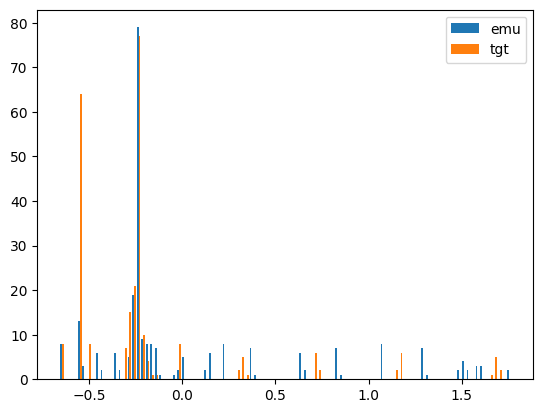

In [128]:
ivar = 2
filtered = w.numpy().flatten()>0.5
emu_vs_tgt = [mu_safe.numpy().flatten()[filtered], y_true_safe.numpy().flatten()[filtered]]
_ = plt.hist(emu_vs_tgt, bins=100)
plt.legend(['emu', 'tgt'])

In [129]:
# Static diagonal preconditioner - pilot run to estimate sigma

initial_state = tf.random.normal([nchains, npar], seed=1) * 0.1
pilot_hmc = tfp.mcmc.HamiltonianMonteCarlo(get_BOSSemu_lp, step_size=0.0005, num_leapfrog_steps=5)
@tf.function
def run_pilot_chain():
    return tfp.mcmc.sample_chain(num_results=100, num_burnin_steps=0,
                                   current_state=initial_state, kernel=pilot_hmc, 
                                   trace_fn=(lambda current_state, kernel_results: kernel_results), 
                                   seed=1)
z_pilot, kr_pilot = run_pilot_chain()

var = tf.math.reduce_variance(z_pilot, axis=[0,1]) + 1e-6
sigma = tf.sqrt(var)  # shape [npar]
print(sigma)

tf.Tensor(
[0.11200701 0.12516655 0.09469686 0.10729609 0.05391108 0.07992505
 0.10604674 0.07960157 0.07613832 0.06124249 0.04440095 0.11897561
 0.07430004 0.06678743 0.05443344 0.06702545], shape=(16,), dtype=float32)


## actual run

In [130]:

stepsize = 0.1
bij = tfb.Blockwise([tfb.Sigmoid()] * npar)
rv0 = tfs.RunningVariance.from_stats(
    num_samples=tf.constant(0., initial_state.dtype),   # “empty” running variance
    mean=tf.zeros([npar], initial_state.dtype),
    variance=tf.ones([npar], initial_state.dtype),         # start with I
)

hmc = tfp.mcmc.HamiltonianMonteCarlo(get_BOSSemu_lp, step_size=stepsize, num_leapfrog_steps=3)
DA = tfp.mcmc.DualAveragingStepSizeAdaptation(
        inner_kernel=hmc,
        num_adaptation_steps=int(num_burnin_steps * 0.5),
        target_accept_prob=0.75,
        )

precond = tfp.bijectors.Scale(sigma)

TTK = tfp.mcmc.TransformedTransitionKernel(
    bijector=precond,
    inner_kernel=DA,
)
# DMMA = tfp.experimental.mcmc.DiagonalMassMatrixAdaptation(
#     inner_kernel=DA,
#     initial_running_variance=[rv0],
#     num_estimation_steps=int(0.8*num_burnin_steps),
# )

nuts = tfp.mcmc.NoUTurnSampler(target_log_prob_fn=get_BOSSemu_lp, step_size=stepsize, max_tree_depth=10)
adaptive_nuts = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=nuts,
    num_adaptation_steps=int(num_burnin_steps * 0.5),
    target_accept_prob=0.65,
)

# Improved MCMC settings
# stepsize = 0.1
# num_burnin_steps = 200
# num_samples = 500

# nuts = tfp.mcmc.NoUTurnSampler(target_log_prob_fn=get_BOSSemu_lp, 
#                                step_size=stepsize, 
#                                max_tree_depth=10)
# adaptive_nuts = tfp.mcmc.DualAveragingStepSizeAdaptation(
#     inner_kernel=nuts,
#     num_adaptation_steps=int(num_burnin_steps * 0.8),
#     target_accept_prob=0.65,
# )

start = time.time()

# @tf.function
# def run_chain():
samples, kr = tfp.mcmc.sample_chain(num_results=num_samples,
        current_state=initial_state,   # or your initial_state
        kernel=TTK,
        num_burnin_steps=num_burnin_steps,
        trace_fn=(lambda current_state, kernel_results: kernel_results),
        seed=0)

# samples, kr = run_chain()

end = time.time()
print(end-start)

632.3164510726929


acceptance rate: [0.9725 0.967  0.957  0.9595 0.956  0.9525]


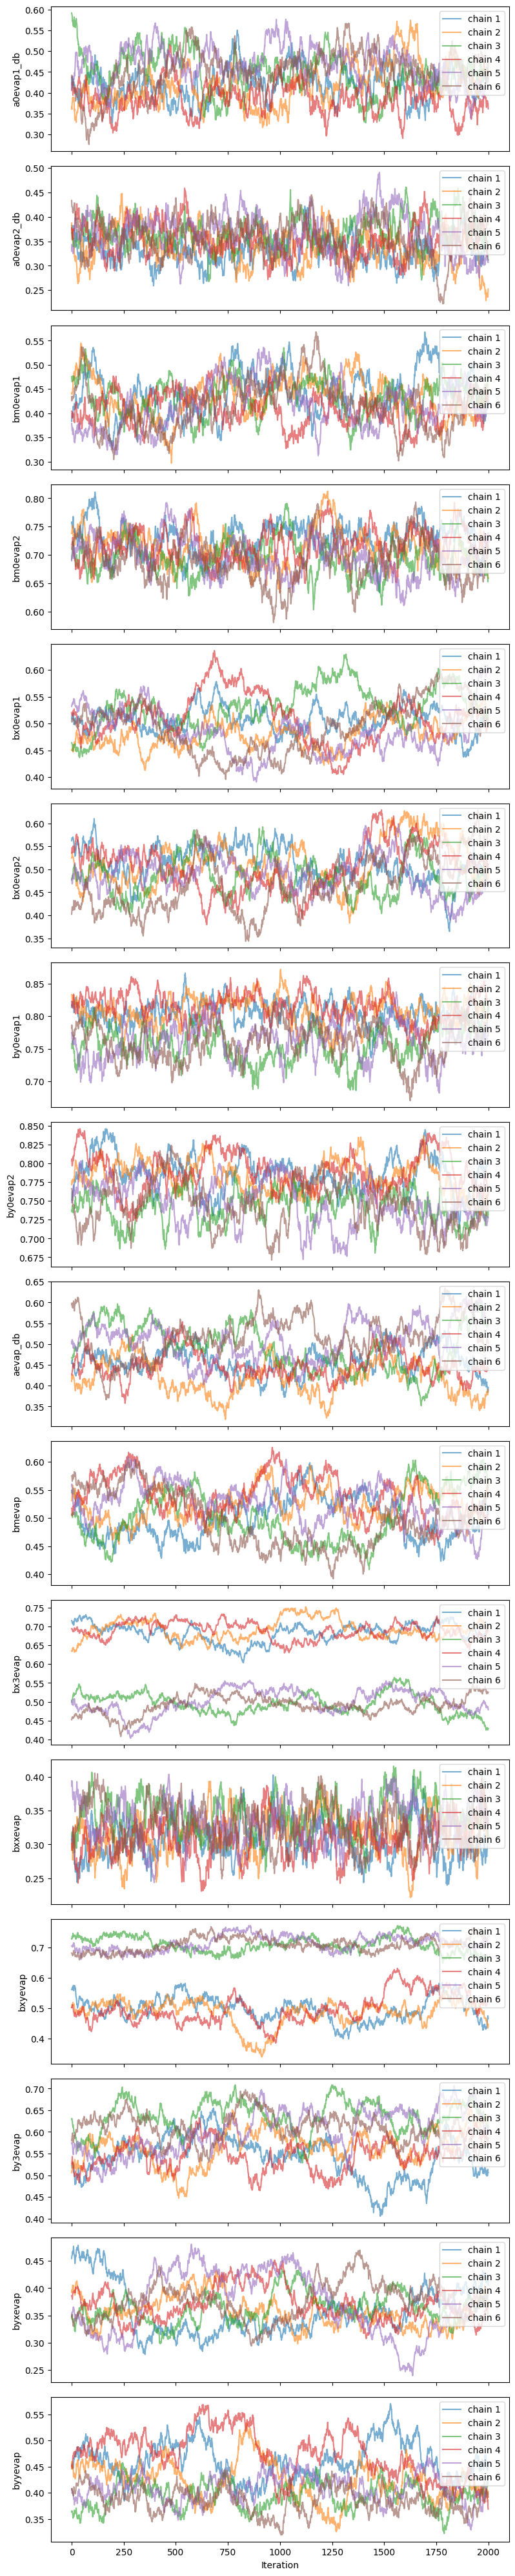

[[27.524567  51.170555  28.038303  36.35318   24.77141   13.522092
  64.27938   27.485619  21.106857   6.769783   9.820956  41.689037
  12.6076565  7.397731   8.198398  12.729123 ]
 [ 8.82848   39.46771   14.853225  24.421988  15.822583  10.239212
  43.33156   18.510466  12.708739  18.099936  10.273213  40.280613
  11.616328  11.271318   8.489902  14.497734 ]
 [18.108904  54.071648  28.356323  26.887957  10.9730015 22.854916
  21.927792  34.26282    6.3565373  7.097727  11.377584  49.184372
  10.857539  18.790829  15.60209   24.184355 ]
 [38.94654   39.03474   30.80548   37.70159    7.3979053  6.0642805
  21.658863  17.337387  16.24364   10.647646  11.415902  45.178883
   5.602433  17.906067   8.604101   8.446517 ]
 [16.605824  21.625412   8.596428  11.52201    8.719317  12.717372
  28.84606   17.917679   8.699333  12.574731   7.701835  39.792164
   8.256628   5.2204556  5.708369  20.531641 ]
 [11.717293  32.669518   9.098774  19.7902     4.6486626  7.314209
  20.863346  14.744653  11.

In [131]:
print("acceptance rate:", sum(kr.inner_results.inner_results.is_accepted.numpy())/num_samples)
# param_names_incl_sigma = param_names + ['sigma']
transformed_samples = tfb.Sigmoid().forward(samples)
# transformed_samples = tf.concat([tfb.Sigmoid().forward(samples[:,:,:-1]), tf.exp(samples[:,:,-1:])], axis=2)
mf.plot_traces(transformed_samples, param_names)

print(tfp.mcmc.effective_sample_size(samples).numpy())
print(tfp.mcmc.potential_scale_reduction(samples).numpy())

In [132]:
print("acc rate:", kr.inner_results.inner_results.is_accepted.numpy().mean())
# print("step_size:", kr.inner_results.step_size.numpy())
print("step_size range:", kr.inner_results.new_step_size.numpy().min(), kr.inner_results.new_step_size.numpy().max())
# print("leapfrog steps avg:", kr.inner_results.leapfrogs_taken.numpy().mean()).
print("avg log_accept_ratio:", np.nanmean(kr.inner_results.inner_results.log_accept_ratio))

acc rate: 0.96075
step_size range: 0.10359252 0.10359252
avg log_accept_ratio: -0.0058914907


In [133]:
with tf.GradientTape() as gt:
  gt.watch(initial_state)
  logprob = get_BOSSemu_lp(initial_state)
grad = gt.gradient(logprob, initial_state)
print("||grad|| ≈", tf.norm(grad).numpy())

||grad|| ≈ 21412.094


In [134]:
with tf.GradientTape() as t:
    t.watch(initial_state)                # unconstrained params you sample in
    lp = get_BOSSemu_lp(initial_state)
g = t.gradient(lp, initial_state)         # shape [..., D]
gn = tf.math.reduce_std(g, axis=0)  # per-dim
print(gn)

tf.Tensor(
[ 169.60353   249.69531    46.105354   30.291903   11.079536   62.956314
   71.11613   180.8882     65.82293    84.43086  5041.2476   5265.3145
  177.48502   188.73651   162.05074    73.56943 ], shape=(16,), dtype=float32)


## postprocessing

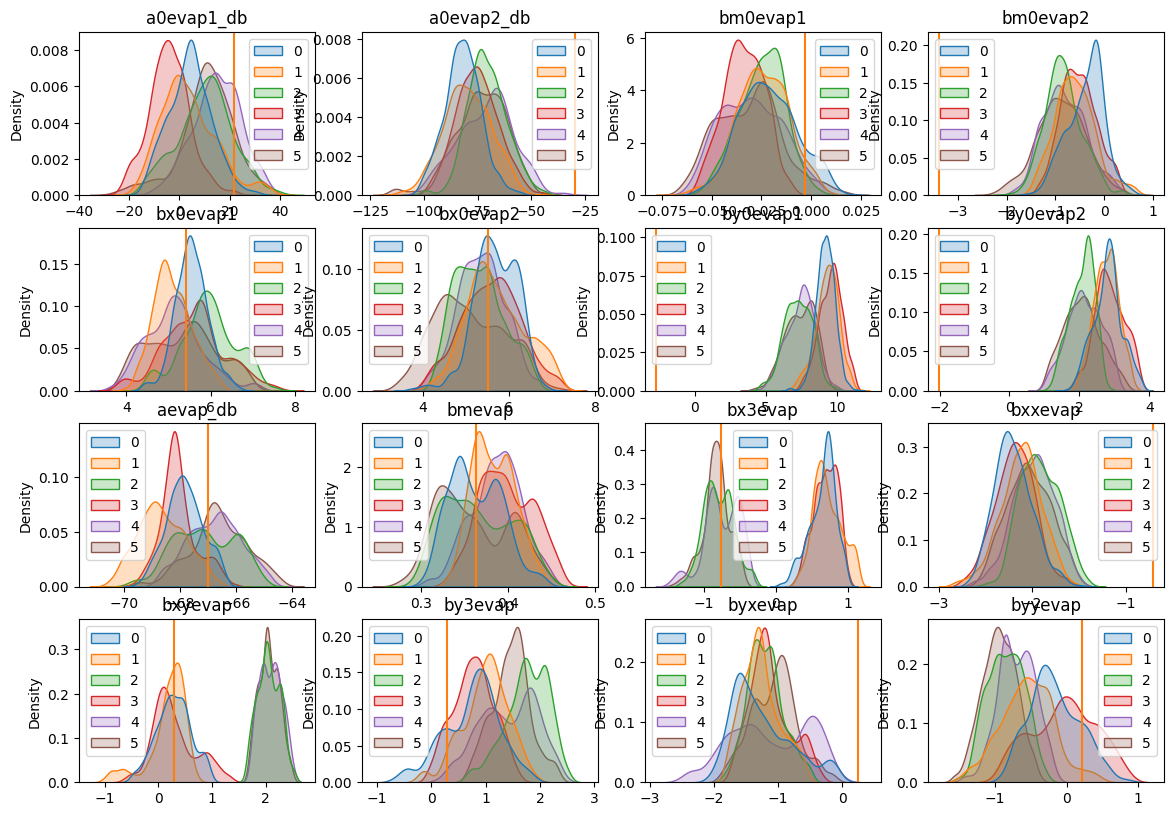

In [135]:
import seaborn as sns

IC_col = tf.tile(tf.expand_dims(IC_norm[0, :n_init], 0), [num_samples, 1])
# IC_col = tf.tile(tf.expand_dims(IC_norm[0, :n_init], 0), [num_samples, 1])
IC_col3d = tf.tile(IC_col[:, None, :], [1, nchains, 1])
# w_col3d = tf.tile(w_col[:, None, :], [1, nchains, 1])
samples_with_ic = tf.concat([IC_col3d, transformed_samples], axis=2)

samples_with_ic_raw_vals = np.zeros(samples_with_ic.shape, dtype=np.float32)
for ichain in range(nchains):
    samples_with_ic_raw_vals[:, ichain, :] = scalers['x'].inverse_transform(samples_with_ic[:, ichain, :])

samples_raw_vals = samples_with_ic_raw_vals[:,:,n_init:]

np.mean(samples_with_ic[:,:,n_init:].numpy().reshape(num_samples*nchains,nparam), axis=0)
# samples_with_ic[:,:,n_init:].shape

samples_origval = samples_raw_vals
fig = plt.figure(figsize=(14,25))
gs = gridspec.GridSpec(10, 4)
for ipost in range(samples_origval.shape[-1]):
# for iparam, param_name in enumerate(param_names):
    param_name = param_names[ipost]
    ax = fig.add_subplot(gs[ipost])
    sns.kdeplot(samples_origval[:,:,ipost], fill=True)
    plt.axvline(param_mean[ipost], color='tab:orange')
    # plt.axvline(target_param_mean[ipost], color='tab:blue')
    plt.title(param_name)

$$
\frac{dM_i}{dt} \propto a_{0,coal}M^2_0\frac{\tilde{m}^{b_{n,i}}}{\tilde{m}^{b_{m}} + m_{trans}^{b_m}}K^{b_{x,i}}_{0,3,x}K^{b_{y,i}}_{3,x,y}
$$

x=4, y=6 for ith order moment

## validation

In [136]:
# importlib.reload(ef)

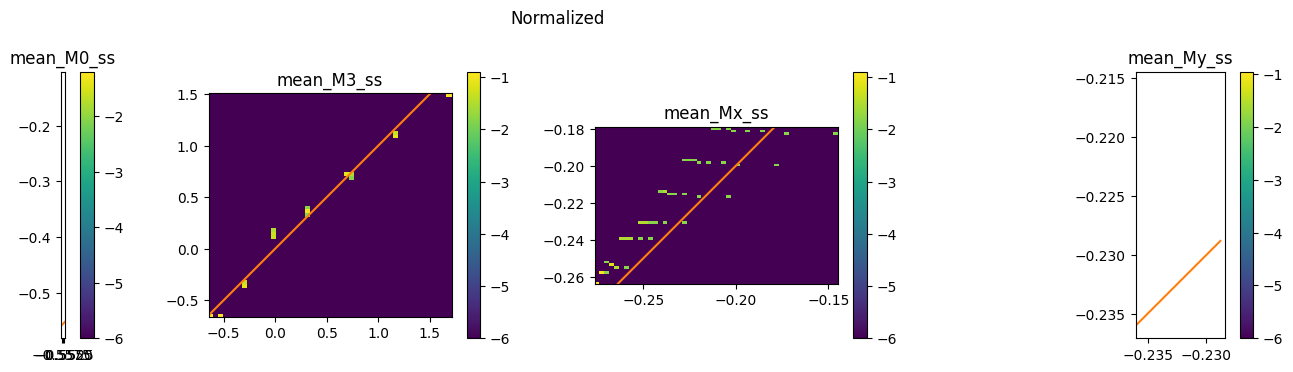

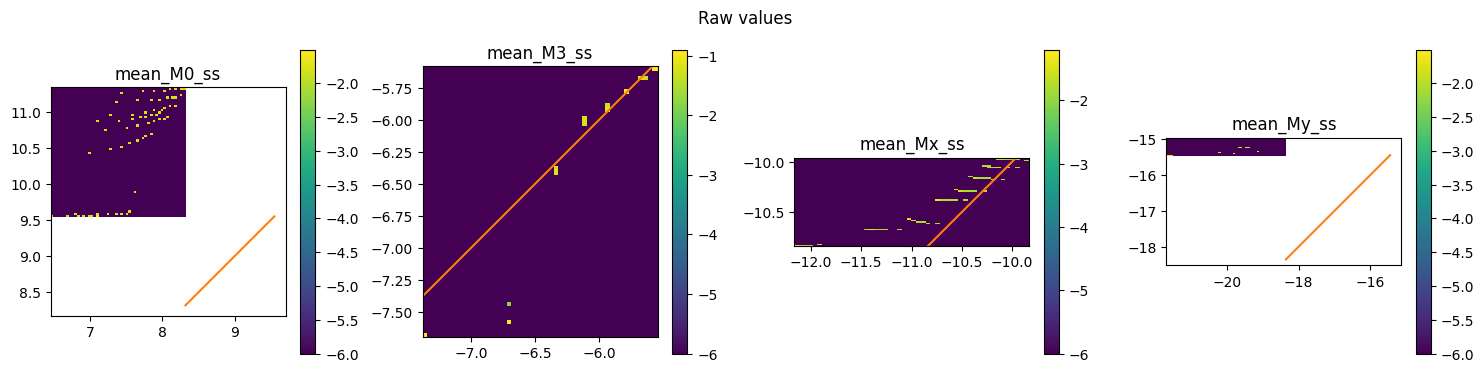

In [137]:
tsamples_combine_chains = transformed_samples.numpy().reshape(num_samples*nchains, npar)
meanresult = np.mean(tsamples_combine_chains, axis=0)
meanresult = tf.expand_dims(meanresult, axis=0)
meanresult_tiled = tf.tile(meanresult, [IC_norm.shape[0], 1])
meanresults_incl_ics = tf.concat([IC_norm, meanresult_tiled], axis=1)

ef.plot_emulator_results(meanresults_incl_ics, tgt_data, best_model, ppe_info, transform_method, scalers)

# Save MCMC results

## save posterior PDF into netCDF

In [39]:
nbins = 50
count = {}
bins = {}
sample_sum_chains = samples_origval.reshape(num_samples*nchains,nparam)
for iparam, param_name in enumerate(param_names):
    count[param_name], bins[param_name] = np.histogram(sample_sum_chains[:, iparam], bins=nbins)
    count[param_name] = count[param_name]/np.sum(count[param_name])

import netCDF4 as nc
import numpy as np

# Create a new NetCDF file
ncfile = nc.Dataset('MCMC_posterior/' + filename[:-3] + '_post.nc', mode='w', format='NETCDF4')

# Create the dimension for parameters and bins
param_dim = ncfile.createDimension('nparam', len(param_names))
binmean_dim = ncfile.createDimension('nbin', nbins)
binedge_dim = ncfile.createDimension('nbinedge', nbins+1)

# Create variables
param_var = ncfile.createVariable('param_names', str, ('nparam',))
density_var = ncfile.createVariable('density', np.float32, ('nparam', 'nbin',))
bin_edges_var = ncfile.createVariable('bin_edges', np.float32, ('nparam', 'nbinedge',))
# sigma_dens_var = ncfile.createVariable('sigma_dens', np.float32, ('nbin',))
# sigma_edge_var = ncfile.createVariable('sigma_edge', np.float32, ('nbinedge',))

# Assign data
param_var[:] = np.array(param_names, dtype='S')
for i, pname in enumerate(param_names):
    # bins[pname] has nbins+1 edges, so we store the left edges for each bin
    density_var[i, :] = count[pname]
    bin_edges_var[i, :] = bins[pname]

# sigma_dens_var[:] = count['sigma'].astype('float32')
# sigma_edge_var[:] = bins['sigma']
ncfile.close()

## update params csv

In [40]:
original_params = pd.read_csv(orig_param_csv)
updated_params = original_params.copy()
for iparam, param_name in enumerate(param_names):
    binmean = (bins[param_name][1:] + bins[param_name][:-1])/2
    weighted_mean = np.average(binmean, weights=count[param_name])
    weighted_std = np.sqrt(np.cov(binmean, aweights=count[param_name], ddof=0))
    updated_params.loc[0, param_name] = weighted_mean
    updated_params.loc[2, param_name] = weighted_std

# coal_density = pd.read_csv('MCMC_posterior/coal_r2_param_density.csv')
# coal_param_names = coal_density.keys()[1:].to_list()
# coal_bin_edges = pd.read_csv('MCMC_posterior/coal_r2_param_bins.csv')

# for iparam, param_name in enumerate(coal_param_names):
#     binmean = (coal_bin_edges[param_name][1:].to_numpy() + coal_bin_edges[param_name][:-1].to_numpy())/2
#     weighted_mean = np.average(binmean, weights=coal_density[param_name])
#     updated_params.loc[0, param_name] = weighted_mean

updated_params.to_csv(orig_param_csv + run_name + '_r1.csv', index=False)
updated_params

,Unnamed: 0,a0evap1_db,a0evap2_db,bm0evap1,bm0evap2,bx0evap1,bx0evap2,by0evap1,by0evap2,aevap_db,...,bnfall,bx0fall,bx3fall,bxxfall,bxyfall,by0fall,by3fall,byxfall,byyfall,mlim_db
0,mean,10.007302,-52.806379,-0.018201,-1.640127,4.142121,5.609050,4.404951,0.395424,-67.768427,...,1.542066,-0.383535,0.937090,0.878926,0.733513,-0.024706,0.510425,1.387850,2.727749,9.035962
1,sd,2.255964,3.114923,0.003238,0.132059,0.168649,0.137407,0.390538,0.169134,0.203477,...,0.220264,0.013566,0.014816,0.015543,0.019498,0.019935,0.021920,0.023036,0.028926,0.800699
2,isd,9.671632,13.074087,0.014690,0.488602,0.668957,0.625820,1.227762,0.609305,0.840090,...,22.026426,1.356642,1.481585,1.554318,1.949807,1.993456,2.191994,2.303620,2.892624,80.069884


In [ ]:
import os
os._exit(00)